In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=42)

In [2]:
def problem1():
    # Problem 1:
    NUM_KNAPSACKS = 3
    NUM_ITEMS = 20
    NUM_DIMENSIONS = 2
    VALUES = rng.integers(0, 100, size=NUM_ITEMS)
    WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
    CONSTRAINTS = rng.integers(
        0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
    )
    
    return NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS

In [3]:
def problem2():
    # Problem 2:
    NUM_KNAPSACKS = 10
    NUM_ITEMS = 100
    NUM_DIMENSIONS = 10
    VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
    WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
    CONSTRAINTS = rng.integers(
        1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
    )
    
    return NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS

In [4]:
def problem3():
    # Problem 3:
    NUM_KNAPSACKS = 100
    NUM_ITEMS = 5000
    NUM_DIMENSIONS = 100
    VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
    WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
    CONSTRAINTS = rng.integers(
        1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
    )
    
    return NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS

In [6]:
def check_constraints(solution, WEIGHTS, CONSTRAINTS):
    """
    Check if a given solution satisfies all knapsack constraints

    Parameters:
    solution: Array of shape (NUM_ITEMS,), each element is -1 (not used) or knapsack index [0..NUM_KNAPSACKS-1]
    WEIGHTS: Array of shape (NUM_ITEMS, NUM_DIMENSIONS) containing the weights of each item per dimension
    CONSTRAINTS: Array of shape (NUM_KNAPSACKS, NUM_DIMENSIONS) with the max capacity of each knapsack per dimension

    Returns:
    valid: True if all constraints are satisfied, False otherwise
    used_capacity: Matrix (NUM_KNAPSACKS, NUM_DIMENSIONS) showing total used capacity per knapsack
    """

    num_knapsacks, num_dims = CONSTRAINTS.shape

    used_capacity = np.zeros((num_knapsacks, num_dims))

    for i,k in enumerate(solution):
        if k==-1:
            continue
        used_capacity[k] += WEIGHTS[i]

    valid = np.all(used_capacity <= CONSTRAINTS)

    return valid, used_capacity

def fitness(solution, VALUES, WEIGHTS, CONSTRAINTS, penalty_factor=10):
    valid, used_capacity = check_constraints(solution, WEIGHTS, CONSTRAINTS)
    total_value = np.sum([VALUES[i] for i,k in enumerate(solution) if k!=-1])
    if valid: 
        return total_value
    else:
        overload = np.maximum(used_capacity - CONSTRAINTS, 0)
        penalty = penalty_factor * np.sum(overload)
        return total_value - penalty
    
def repair_solution(solution, WEIGHTS, CONSTRAINTS, VALUES):
    """
    Ensures a solution is feasible by removing items that exceed capacity constraints.
    Items are removed starting from those with the lowest value/weight ratio.
    """
    solution = solution.copy()
    used_capacity = np.zeros_like(CONSTRAINTS, dtype=float)
    
    #Compute initial usage
    for i, k in enumerate(solution):
        if k == -1:
            continue
        used_capacity[k] += WEIGHTS[i]
    
    #For each knapsack check capacity
    for k in range(CONSTRAINTS.shape[0]):
        while np.any(used_capacity[k] > CONSTRAINTS[k]):
            #Find which items are in this knapsack
            items_in_k = [i for i, assign in enumerate(solution) if assign == k]
            if not items_in_k:
                break
            
            #Compute value/weight ratio to remove least valuable
            ratios = [
                VALUES[i] / (np.sum(WEIGHTS[i]) + 1e-6)
                for i in items_in_k
            ]
            worst_item = items_in_k[np.argmin(ratios)]
            
            #Remove that item
            solution[worst_item] = -1
            used_capacity[k] -= WEIGHTS[worst_item]
    
    return solution

In [7]:
def simulated_annealing(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS,
                        max_iter=5000, initial_temp=100, cooling_rate=0.995, penalty_factor=1000):
    #Initialize solution
    current_solution = rng.integers(-1, NUM_KNAPSACKS, size=NUM_ITEMS)
    current_solution = repair_solution(current_solution, WEIGHTS, CONSTRAINTS, VALUES)
    current_fitness = fitness(current_solution, VALUES, WEIGHTS, CONSTRAINTS, penalty_factor)
    
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    
    fitness_history = [current_fitness]
    temp = initial_temp

    #Main loop
    for iteration in range(max_iter):
        #Create a neighbor by mutating one or more items
        neighbor = current_solution.copy()
        num_changes = rng.integers(1, 4)  #randomly change 1–3 items
        mutation_idx = rng.choice(NUM_ITEMS, size=num_changes, replace=False)
        neighbor[mutation_idx] = rng.integers(-1, NUM_KNAPSACKS, size=num_changes)
        
        #Repair to ensure feasibility
        neighbor = repair_solution(neighbor, WEIGHTS, CONSTRAINTS, VALUES)
        
        #Evaluate
        neighbor_fitness = fitness(neighbor, VALUES, WEIGHTS, CONSTRAINTS, penalty_factor)
        delta = neighbor_fitness - current_fitness

        #Acceptance criterion
        if delta > 0 or rng.random() < np.exp(delta / temp):
            current_solution = neighbor
            current_fitness = neighbor_fitness

            if current_fitness > best_fitness:
                best_solution = current_solution.copy()
                best_fitness = current_fitness
        
        #Cool down
        temp *= cooling_rate
        fitness_history.append(current_fitness)

        #Logging
        if iteration % 500 == 0 or iteration == max_iter - 1:
            print(f"Iter {iteration:4d} | Temp={temp:.4f} | Best={best_fitness:.2f} | Current={current_fitness:.2f}")

        #Early stopping if temperature is too low
        if temp < 1e-5:
            break

    #Visualization
    plt.figure(figsize=(9, 4))
    plt.plot(fitness_history, color="royalblue")
    plt.title("Simulated Annealing Progress")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.show()
    
    return best_solution, best_fitness

Iter    0 | Temp=99.5000 | Best=1584725.00 | Current=1584725.00
Iter  500 | Temp=8.1164 | Best=1613316.00 | Current=1613316.00
Iter 1000 | Temp=0.6621 | Best=1631543.00 | Current=1631543.00
Iter 1500 | Temp=0.0540 | Best=1648210.00 | Current=1648210.00
Iter 2000 | Temp=0.0044 | Best=1659576.00 | Current=1659576.00
Iter 2500 | Temp=0.0004 | Best=1669834.00 | Current=1669834.00
Iter 3000 | Temp=0.0000 | Best=1684983.00 | Current=1684983.00


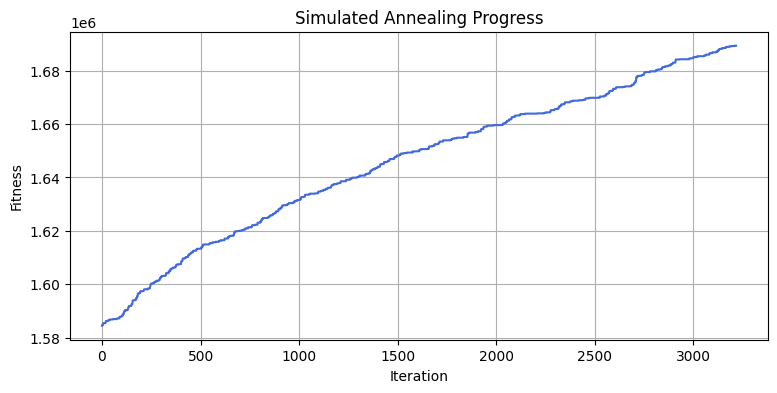


Best solution: [-1 91 -1 ... 90 -1 -1]
Valid: True
Used capacity:
 [[14836. 12503.  8846. ... 12711. 12213. 10284.]
 [10150.  9550. 12196. ... 12781. 11594. 13199.]
 [ 8714.  7331.  9091. ...  7352. 10694. 10760.]
 ...
 [11552. 10987. 11389. ... 14839. 12782. 10047.]
 [12725. 12679. 11805. ... 12649. 12878.  9491.]
 [15420. 16811. 15724. ... 12769. 13633. 13546.]]
Total value: 1689339


In [12]:
NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS = problem3()

best_sol, best_fit = simulated_annealing(
    NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS,
    max_iter=5000, initial_temp=100, cooling_rate=0.995
)

print("\nBest solution:", best_sol)
valid, used_capacity = check_constraints(best_sol, WEIGHTS, CONSTRAINTS)
print("Valid:", valid)
print("Used capacity:\n", used_capacity)
print("Total value:", np.sum([VALUES[i] for i, k in enumerate(best_sol) if k != -1]))

In [13]:
def genetic_algorithm(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS,
                      pop_size=100, generations=100, crossover_prob=0.8, mutation_prob=0.1, penalty_factor=1000):

    population = rng.integers(-1, NUM_KNAPSACKS, size=(pop_size, NUM_ITEMS))
    
    best_history, avg_history = [], []

    for gen in range(generations):
        fitness_values = np.array([fitness(ind, VALUES, WEIGHTS, CONSTRAINTS, penalty_factor=10) for ind in population])
        
        #Stats
        best_idx = np.argmax(fitness_values)
        best_val = fitness_values[best_idx]
        avg_val = np.mean(fitness_values)

        best_history.append(best_val)
        avg_history.append(avg_val)

        #Elitism: keep the best
        elite = population[best_idx].copy()
        new_population = [elite]
            
        #Reproduction
        while len(new_population) < pop_size:
            #Tournament selection
            i1, i2 = rng.choice(pop_size, 2, replace=False)
            parent1 = population[i1] if fitness_values[i1] > fitness_values[i2] else population[i2]

            j1, j2 = rng.choice(pop_size, 2, replace=False)
            parent2 = population[j1] if fitness_values[j1] > fitness_values[j2] else population[j2]

            #Crossover
            if rng.random() < crossover_prob:
                mask = rng.random(NUM_ITEMS) < 0.5
                child = np.where(mask, parent1, parent2)
            else:
                child = parent1.copy()
            
            #Mutation
            mutation_mask = rng.random(NUM_ITEMS) < mutation_prob
            child[mutation_mask] = rng.integers(-1, NUM_KNAPSACKS, size=np.sum(mutation_mask))
            child = repair_solution(child, WEIGHTS, CONSTRAINTS, VALUES)
            
            new_population.append(child)
        
        population = np.array(new_population)
        
        if gen % 10 == 0 or gen == generations - 1:
            print(f"Gen {gen:3d} | Best: {best_val:.2f} | Avg: {avg_val:.2f}")


    #Final evaluation
    final_fitness = np.array([
        fitness(ind, VALUES, WEIGHTS, CONSTRAINTS, penalty_factor=10)
        for ind in population
    ])
    best_idx = np.argmax(final_fitness)
    best_solution = population[best_idx]
    best_value = final_fitness[best_idx]

    #Visualization
    plt.figure(figsize=(9, 4))
    plt.plot(best_history, label="Best fitness", linewidth=2)
    plt.plot(avg_history, label="Average fitness", linestyle="--")
    plt.title("Genetic Algorithm Progress")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_solution, best_value

Gen   0 | Best: -225502.00 | Avg: -465414.62
Gen  10 | Best: 39885.00 | Avg: 34879.15
Gen  20 | Best: 40494.00 | Avg: 35532.41
Gen  30 | Best: 40494.00 | Avg: 35955.91
Gen  40 | Best: 40494.00 | Avg: 35656.23
Gen  50 | Best: 41291.00 | Avg: 35479.44
Gen  60 | Best: 41291.00 | Avg: 35513.96
Gen  70 | Best: 41291.00 | Avg: 35389.26
Gen  80 | Best: 41565.00 | Avg: 35617.85
Gen  90 | Best: 41565.00 | Avg: 35315.82
Gen  99 | Best: 41997.00 | Avg: 35734.52


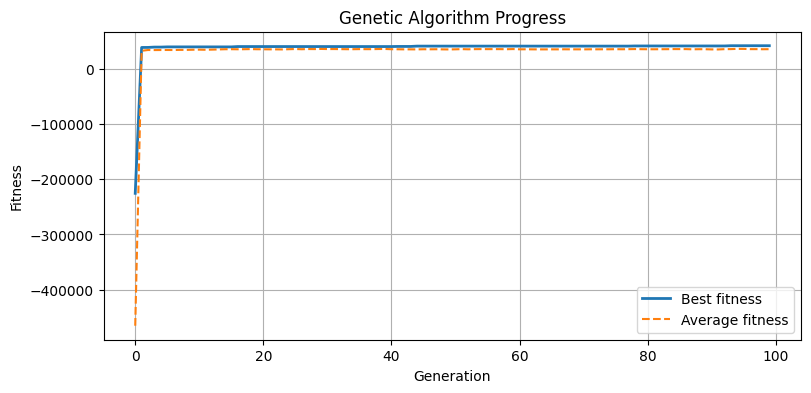


Best solution: [ 8  9  5  3 -1  6  7  1  4 -1 -1  6 -1  3 -1  1  4 -1  5  9  2  9  4 -1
  8  8 -1  4 -1 -1  8 -1  3  2 -1  5 -1 -1 -1 -1 -1  6 -1 -1  9  5 -1  7
 -1  6  3  3  6 -1  5  4 -1  8  0 -1 -1  8 -1  8 -1  7  7  9 -1 -1  8  8
  0  6  5  2  0  1 -1  7  2 -1  3 -1  6  9  0  7  7  7  6  3  7 -1 -1 -1
 -1 -1  8  1]
Valid: True
Used capacity:
 [[2156. 2429. 2441. 1269. 2911. 2545. 1452. 2362. 1625. 1755.]
 [2896. 2181. 1509. 1963. 1819.  903. 1594. 2157. 1817. 1729.]
 [2199. 1384. 1635. 2140. 2784. 2207. 1920. 2387. 2273. 1625.]
 [4222. 3151. 3349. 3801. 4784. 1775. 3020. 3203. 3535. 4271.]
 [2030. 3171. 2642. 1894. 2244. 2466. 1716. 1756. 1217. 2134.]
 [4359.  964. 2406. 3142. 3421. 2336. 2467. 2657. 3421. 2904.]
 [4124. 4106. 4459. 3696. 3690. 2683. 4591. 3432. 3514. 5261.]
 [4267. 4286. 5001. 4112. 4072. 4004. 2834. 3548. 5644. 4736.]
 [5220. 5634. 5587. 5874. 2736. 4294. 4664. 3403. 3652. 7125.]
 [2478. 4232. 2404. 3812. 2746. 3949. 3644. 2992. 3187. 1679.]]
Total value: 41997


In [ ]:
NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS = problem2()

best_solution, best_fitness = genetic_algorithm(NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS)

print("\nBest solution:", best_solution)
valid, used_capacity = check_constraints(best_solution, WEIGHTS, CONSTRAINTS)
print("Valid:", valid)
print("Used capacity:\n", used_capacity)
print("Total value:", np.sum([VALUES[i] for i, k in enumerate(best_solution) if k != -1]))

In [19]:
def heuristic(solution_matrix, VALUES, WEIGHTS, CONSTRAINTS):
    """
    Computes the heuristic desirability for assigning each item to each knapsack.
    """
    num_knapsacks = CONSTRAINTS.shape[0]
    num_items = VALUES.shape[0]
    eta = np.zeros((num_items, num_knapsacks + 1))
    for i in range(num_items):
        for k in range(num_knapsacks):
            weight_ratio = np.sum(WEIGHTS[i]/CONSTRAINTS[k])
            eta[i, k] = VALUES[i] / (weight_ratio + 1e-6)
        eta[i, num_knapsacks] = 1
    return eta

def ant_colony(NUM_ITEMS, NUM_KNAPSACKS, VALUES, WEIGHTS, CONSTRAINTS, NUM_ANTS=50, NUM_GENERATIONS=100, alpha=1, beta=2, evaporation_rate=0.1, penalty_factor=10):
    pheromone = np.ones((NUM_ITEMS, NUM_KNAPSACKS+1))
    eta = heuristic(pheromone, VALUES, WEIGHTS, CONSTRAINTS)

    best_solution = None
    best_fitness = -np.inf
    fitness_history = []

    #Main ACO loop
    for gen in range(NUM_GENERATIONS):
        ant_solutions = []
        ant_fitness = []

        #Each ant builds a complete solution
        for ant in range(NUM_ANTS):
            solution = []
            for i in range(NUM_ITEMS):
                #Compute probability of assigning an item to each knapsack or to none
                probs = np.zeros(NUM_KNAPSACKS+1)
                for k in range(NUM_KNAPSACKS+1):
                    probs[k] = (pheromone[i, k]**alpha)*(eta[i, k]**beta)
                probs = np.maximum(probs, 1e-6)
                probs /= probs.sum()
                #Randomly select a knapsack according to the computed probabilities
                chosen_k = np.random.choice(NUM_KNAPSACKS+1, p=probs)
                solution.append(chosen_k if chosen_k != NUM_KNAPSACKS else -1)
            ant_solutions.append(solution)
            f = fitness(solution, VALUES, WEIGHTS, CONSTRAINTS, penalty_factor)
            ant_fitness.append(f)

            if f > best_fitness:
                best_fitness = f
                best_solution = solution.copy()

        #Pheromone update
        pheromone *= (1 - evaporation_rate) #global evaporation
        for sol, f in zip(ant_solutions, ant_fitness):
            for i, k in enumerate(sol):
                index = k if k != -1 else NUM_KNAPSACKS
                #Deposit pheromone proportional to the solution's fitness
                pheromone[i, index] += f/1000.0

        fitness_history.append(best_fitness)

        if gen % 10 == 0 or gen == NUM_GENERATIONS-1:
            print(f"Generation {gen+1}, best fitness: {best_fitness}")

    #Visualization
    plt.figure(figsize=(10,5))
    plt.plot(fitness_history, marker='o', linestyle='-')
    plt.title("ACO: Best Fitness Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.grid(True)
    plt.show()

    return best_solution, best_fitness

Generation 1, best fitness: -400.0
Generation 11, best fitness: 817
Generation 21, best fitness: 887
Generation 31, best fitness: 926
Generation 41, best fitness: 926
Generation 51, best fitness: 926
Generation 61, best fitness: 926
Generation 71, best fitness: 926
Generation 81, best fitness: 926
Generation 91, best fitness: 926
Generation 100, best fitness: 926


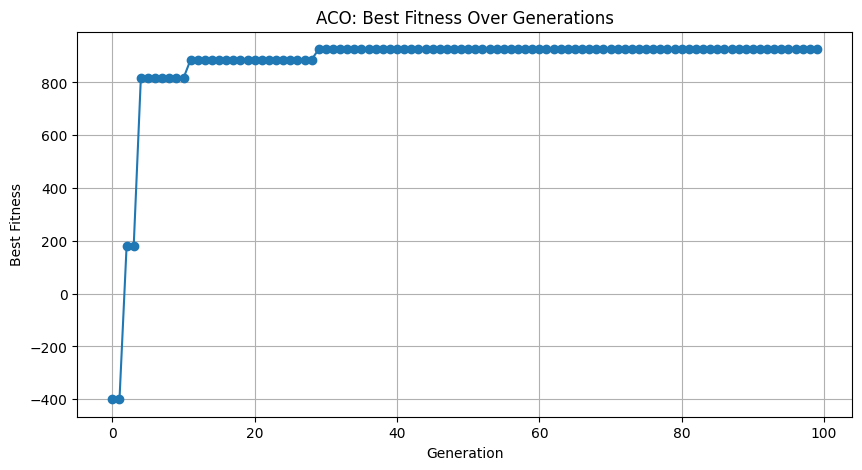


Best solution: [2, -1, 0, 0, 0, 0, 0, -1, 2, 1, 1, 2, 0, 2, 2, 0, 2, -1, -1, -1]
Valid: True
Used capacity:
 [[335. 503.]
 [ 38.  84.]
 [344. 361.]]
Total value: 926


In [27]:
NUM_KNAPSACKS, NUM_ITEMS, NUM_DIMENSIONS, VALUES, WEIGHTS, CONSTRAINTS = problem1()

best_solution, best_fitness = ant_colony(NUM_ITEMS, NUM_KNAPSACKS, VALUES, WEIGHTS, CONSTRAINTS, NUM_ANTS=30, NUM_GENERATIONS=100)

print("\nBest solution:", best_solution)
valid, used_capacity = check_constraints(best_solution, WEIGHTS, CONSTRAINTS)
print("Valid:", valid)
print("Used capacity:\n", used_capacity)
print("Total value:", np.sum([VALUES[i] for i, k in enumerate(best_solution) if k != -1]))